# Task 1

In [4]:
import pandas as pd
import ast
from sklearn.feature_extraction.text import TfidfVectorizer
from scipy.sparse import hstack
from scipy.sparse import save_npz
import joblib


### Step 1: Load the disease features dataset

In [5]:
df = pd.read_csv("disease_features.csv")

### Step 2: Parse and convert lists into strings

In [6]:
def parse_and_flatten_column(column):
    return df[column].apply(lambda x: " ".join(ast.literal_eval(x)) if pd.notna(x) and x.strip() else "")

df["Risk Factors Clean"] = parse_and_flatten_column("Risk Factors")
df["Symptoms Clean"] = parse_and_flatten_column("Symptoms")
df["Signs Clean"] = parse_and_flatten_column("Signs")
df["Subtypes Clean"] = parse_and_flatten_column("Subtypes")  

### Step 3 & 4: TF-IDF vectorization for each column

In [7]:
vectorizer_risk = TfidfVectorizer()
vectorizer_symptoms = TfidfVectorizer()
vectorizer_signs = TfidfVectorizer()
vectorizer_subtypes = TfidfVectorizer()

tfidf_risk = vectorizer_risk.fit_transform(df["Risk Factors Clean"])
tfidf_symptoms = vectorizer_symptoms.fit_transform(df["Symptoms Clean"])
tfidf_signs = vectorizer_signs.fit_transform(df["Signs Clean"])
tfidf_subtypes = vectorizer_subtypes.fit_transform(df["Subtypes Clean"])  # ✅

### Step 5: Combine all TF-IDF matrices into one

In [8]:
tfidf_combined = hstack([tfidf_risk, tfidf_symptoms, tfidf_signs, tfidf_subtypes])

### Step 6: Compare with the one-hot encoded matrix

In [9]:
encoded_df = pd.read_csv("encoded_output2.csv")
encoded_matrix = encoded_df.drop(columns=["Disease"]).values

### Step 7: Summary comparison

In [10]:
comparison = {
    "TF-IDF Matrix Shape": tfidf_combined.shape,
    "One-Hot Matrix Shape": encoded_matrix.shape,
    "TF-IDF Sparsity (%)": 100.0 * (1.0 - tfidf_combined.nnz / (tfidf_combined.shape[0] * tfidf_combined.shape[1])),
    "One-Hot Sparsity (%)": 100.0 * (1.0 - (encoded_matrix != 0).sum() / encoded_matrix.size),
    "TF-IDF Unique Features": tfidf_combined.shape[1],
    "One-Hot Unique Features": encoded_matrix.shape[1],
}

In [11]:
# Save TF-IDF matrix
save_npz("tfidf_combined_matrix.npz", tfidf_combined)


In [12]:
# Save the vectorizers if needed later
joblib.dump(vectorizer_risk, "vectorizer_risk.pkl")
joblib.dump(vectorizer_symptoms, "vectorizer_symptoms.pkl")
joblib.dump(vectorizer_signs, "vectorizer_signs.pkl")
joblib.dump(vectorizer_subtypes, "vectorizer_subtypes.pkl")

['vectorizer_subtypes.pkl']

In [13]:
# Display results
for key, value in comparison.items():
    print(f"{key}: {value}")

TF-IDF Matrix Shape: (25, 1125)
One-Hot Matrix Shape: (25, 496)
TF-IDF Sparsity (%): 93.21244444444444
One-Hot Sparsity (%): 95.33870967741936
TF-IDF Unique Features: 1125
One-Hot Unique Features: 496


# Task 2

In [14]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import PCA, TruncatedSVD
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
from scipy.sparse import load_npz

In [15]:
# Load datasets
df = pd.read_csv("disease_features.csv")
encoded_df = pd.read_csv("encoded_output2.csv")
# Load the saved TF-IDF matrix
tfidf_combined = load_npz("tfidf_combined_matrix.npz")

### Prepare one-hot matrix

In [16]:
encoded_matrix = encoded_df.drop(columns=["Disease"]).values

### Dimensionality Reduction

In [17]:
pca_onehot = PCA(n_components=3)
pca_onehot_result = pca_onehot.fit_transform(encoded_matrix)
pca_variance = pca_onehot.explained_variance_ratio_

svd_tfidf = TruncatedSVD(n_components=3)
svd_tfidf_result = svd_tfidf.fit_transform(tfidf_combined)
svd_variance = svd_tfidf.explained_variance_ratio_

### Create mock disease categories for coloring

In [18]:
categories = ['cardiovascular', 'neurological', 'respiratory', 'metabolic', 'infectious']
category_labels = [categories[i % len(categories)] for i in range(len(encoded_df))]
le = LabelEncoder()
color_labels = le.fit_transform(category_labels)

In [19]:
# Plotting function
def plot_2d(data, title, labels):
    plt.figure(figsize=(8, 6))
    scatter = plt.scatter(data[:, 0], data[:, 1], c=labels, cmap='tab10', s=80, edgecolor='k')
    plt.title(title)
    plt.xlabel("Component 1")
    plt.ylabel("Component 2")
    plt.grid(True)
    plt.colorbar(scatter, ticks=range(len(set(labels))), label='Category')
    plt.show()

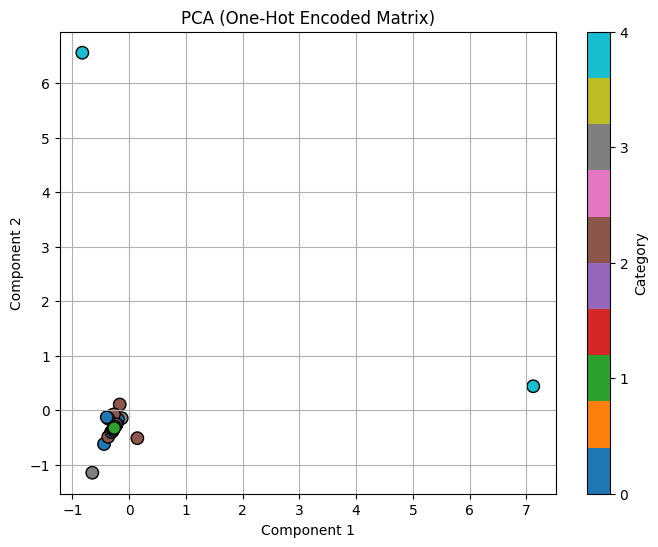

In [20]:
# Plot results
plot_2d(pca_onehot_result, "PCA (One-Hot Encoded Matrix)", color_labels)

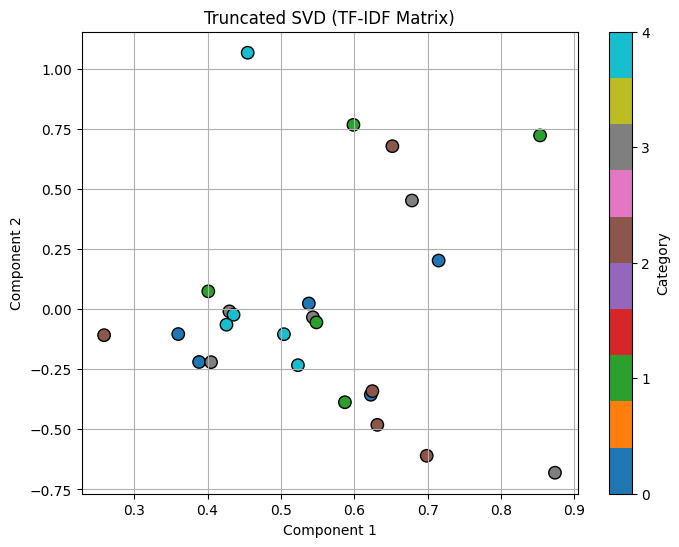

In [21]:
plot_2d(svd_tfidf_result, "Truncated SVD (TF-IDF Matrix)", color_labels)

### Print variance ratios

In [22]:
print("PCA (One-Hot) Explained Variance Ratio:", pca_variance)
print("Truncated SVD (TF-IDF) Explained Variance Ratio:", svd_variance)

PCA (One-Hot) Explained Variance Ratio: [0.10538866 0.09170854 0.06776557]
Truncated SVD (TF-IDF) Explained Variance Ratio: [0.00689739 0.05894642 0.05205389]


# Task 3

In [23]:
import numpy as np
from sklearn.model_selection import cross_validate, StratifiedKFold
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import make_scorer, accuracy_score, precision_score, recall_score, f1_score
from sklearn.preprocessing import LabelEncoder

In [24]:
# Load data
df = pd.read_csv("encoded_output2_with_categories.csv")
tfidf_matrix = load_npz("tfidf_combined_matrix.npz")

### Extract labels and one-hot encoded features

In [25]:
labels = LabelEncoder().fit_transform(df['Category'])
one_hot_features = df.drop(columns=['Disease', 'Category']).values

### Define scoring metrics

In [26]:
scoring = {
    'accuracy': make_scorer(accuracy_score),
    'precision_macro': make_scorer(precision_score, average='macro', zero_division=0),
    'recall_macro': make_scorer(recall_score, average='macro', zero_division=0),
    'f1_macro': make_scorer(f1_score, average='macro', zero_division=0)
}

### Cross-validation setup

In [27]:
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

### Distance metrics for KNN

In [28]:
distance_metrics = {
    'euclidean': 'euclidean',
    'manhattan': 'manhattan',
    'cosine': 'cosine'
}

### Evaluate KNN

In [29]:
def evaluate_knn(X, y, dataset_name):
    results = []
    for k in [3, 5, 7]:
        for metric_name, metric in distance_metrics.items():
            model = KNeighborsClassifier(n_neighbors=k, metric=metric)
            scores = cross_validate(model, X, y, cv=cv, scoring=scoring)
            results.append({
                'Model': 'KNN',
                'Dataset': dataset_name,
                'k': k,
                'Metric': metric_name,
                'Accuracy': np.mean(scores['test_accuracy']),
                'Precision': np.mean(scores['test_precision_macro']),
                'Recall': np.mean(scores['test_recall_macro']),
                'F1-Score': np.mean(scores['test_f1_macro'])
            })
    return results

### Evaluate Logistic Regression

In [30]:
def evaluate_logreg(X, y, dataset_name):
    model = LogisticRegression(max_iter=1000)
    scores = cross_validate(model, X, y, cv=cv, scoring=scoring)
    return [{
        'Model': 'Logistic Regression',
        'Dataset': dataset_name,
        'k': None,
        'Metric': None,
        'Accuracy': np.mean(scores['test_accuracy']),
        'Precision': np.mean(scores['test_precision_macro']),
        'Recall': np.mean(scores['test_recall_macro']),
        'F1-Score': np.mean(scores['test_f1_macro'])
    }]

In [31]:
# Run all evaluations
results = []
results += evaluate_knn(one_hot_features, labels, 'One-Hot')
results += evaluate_knn(tfidf_matrix, labels, 'TF-IDF')
results += evaluate_logreg(one_hot_features, labels, 'One-Hot')
results += evaluate_logreg(tfidf_matrix, labels, 'TF-IDF')

In [32]:
# Convert results to DataFrame and sort
results_df = pd.DataFrame(results)
results_df = results_df.sort_values(by=["Model", "Dataset", "k", "Metric"]).reset_index(drop=True)

In [33]:
# Display results
print(results_df)

                  Model  Dataset    k     Metric  Accuracy  Precision  Recall  \
0                   KNN  One-Hot  3.0     cosine      0.48   0.266667   0.425   
1                   KNN  One-Hot  3.0  euclidean      0.40   0.224167   0.375   
2                   KNN  One-Hot  3.0  manhattan      0.40   0.224167   0.375   
3                   KNN  One-Hot  5.0     cosine      0.40   0.220833   0.350   
4                   KNN  One-Hot  5.0  euclidean      0.36   0.167500   0.325   
5                   KNN  One-Hot  5.0  manhattan      0.36   0.167500   0.325   
6                   KNN  One-Hot  7.0     cosine      0.40   0.279167   0.350   
7                   KNN  One-Hot  7.0  euclidean      0.36   0.175000   0.300   
8                   KNN  One-Hot  7.0  manhattan      0.36   0.175000   0.300   
9                   KNN   TF-IDF  3.0     cosine      0.52   0.316667   0.450   
10                  KNN   TF-IDF  3.0  euclidean      0.40   0.225000   0.350   
11                  KNN   TF

In [ ]:
# Optional: Save to CSV
#results_df.to_csv("model_comparison_results.csv", index=False)